In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [2]:
import matplotlib.pyplot as plt
import torch
from sdm.models import S2Dataset

In [3]:
from torchvision.transforms import v2
img_transforms = v2.Compose([
    # Rotate
    v2.RandomRotation(30, expand=True),
    # Flip
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    # Affine
    v2.RandomAffine(10, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
    v2.Resize((304, 304)),
])

In [4]:
dataset = S2Dataset(transforms=img_transforms)
n_input_bands = len(dataset.input_bands)

In [5]:
# import dataloader and split into train and validation
from torch.utils.data import DataLoader, random_split

batch_size = 32
validation_split = .2


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)

test_dataloader.dataset.dataset.transforms = None

In [6]:
dataset[0][0].shape

torch.Size([7, 304, 304])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# set mac m1 device
device = torch.device('mps')

# Define the CNN model
# TODO: Add dropout
class SimpleCNN(nn.Module):
    """
    Vegetation Height Prediction CNN

    The model architectures uses a simple CNN with 3 convolutional layers and a gated skip connection.
    The gated skip connection is used to allow the model to use values from the original input to predict the output ina flexible way combining them with the higher dimensional features learned by the CNN.
    The logic behind this is that the CNN can focus on learning whether something is vegetation or not and the skip connection provides information from the canopy height model to help predict the vegetation height.

    Args:
        in_channels (int): Number of input channels (number of bands)
        tile_size (int): Size of the input tile. Defaults to 304.
    """
    def __init__(self, in_channels, tile_size=304):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # output 1 channel

        # Match the number of output channels with the input for skip connection
        self.match_dim = nn.Conv2d(in_channels, 1, kernel_size=1)  # 1x1 convolution
        
        # For the gating mechanism
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        original_x = x
        x = self.bn1(nn.functional.relu(self.conv1(x)))
        x = nn.functional.relu(self.conv2(x))
        x = self.conv3(x)

        # Match the dimensions
        original_x_matched = self.match_dim(original_x)
        
        # Get the gating values from the original input
        gate_values = self.gate(original_x)
        
        x = x + gate_values * original_x_matched  # element-wise multiplication followed by addition

        return x.squeeze(1)



# Initialize the model, loss, and optimizer
model = SimpleCNN(n_input_bands)
criterion = nn.MSELoss()  # Mean Squared Error for regression task
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = model.to(device)
criterion = criterion.to(device)

loss_results = []

# Training loop
model.train()
n_epochs = 5  # Number of epochs
early_stop = 3  # Stop if the validation loss does not improve after 5 epochs
best_val_loss = 1e10  # Set initial best validation loss to infinity
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    for i, (inputs, target, idxs) in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch {epoch}/{n_epochs} Batch {i+1}/{len(train_dataloader)} Loss: {loss.item():.4f} RMSE: {loss.item()**0.5:.4f}")
    avg_loss_train = epoch_loss/len(train_dataloader)
    print(f"Epoch {epoch}/{n_epochs} Loss: {avg_loss_train} RMSE: {avg_loss_train**0.5:.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for i, (inputs, target, idxs) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            target = target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, target)
            epoch_loss += loss.item()
        avg_loss_val = epoch_loss/len(test_dataloader)
        
        print(f"Epoch {epoch}/{n_epochs} Validation Loss: {avg_loss_val} RMSE: {avg_loss_val**0.5:.4f}")
    
    loss_results.append({'train': avg_loss_train, 'val': avg_loss_val})
    scheduler.step()
    # Early stopping
    if avg_loss_val < best_val_loss:
        best_val_loss = avg_loss_val
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop:
            print('Early stopping!')
            break

# Save the model
# torch.save(model.state_dict(), "simple_cnn_model.pth")


Epoch 1/5 Batch 1/51 Loss: 4.9289 RMSE: 2.2201
Epoch 1/5 Batch 2/51 Loss: 6.0312 RMSE: 2.4559
Epoch 1/5 Batch 3/51 Loss: 6.5354 RMSE: 2.5565
Epoch 1/5 Batch 4/51 Loss: 3.1967 RMSE: 1.7879
Epoch 1/5 Batch 5/51 Loss: 2.0034 RMSE: 1.4154
Epoch 1/5 Batch 6/51 Loss: 2.3393 RMSE: 1.5295
Epoch 1/5 Batch 7/51 Loss: 1.7347 RMSE: 1.3171
Epoch 1/5 Batch 8/51 Loss: 1.8539 RMSE: 1.3616
Epoch 1/5 Batch 9/51 Loss: 2.5637 RMSE: 1.6012
Epoch 1/5 Batch 10/51 Loss: 1.6212 RMSE: 1.2733
Epoch 1/5 Batch 11/51 Loss: 2.1153 RMSE: 1.4544
Epoch 1/5 Batch 12/51 Loss: 1.6051 RMSE: 1.2669
Epoch 1/5 Batch 13/51 Loss: 1.8478 RMSE: 1.3594
Epoch 1/5 Batch 14/51 Loss: 1.4264 RMSE: 1.1943
Epoch 1/5 Batch 15/51 Loss: 1.7285 RMSE: 1.3147
Epoch 1/5 Batch 16/51 Loss: 2.0081 RMSE: 1.4171
Epoch 1/5 Batch 17/51 Loss: 2.3706 RMSE: 1.5397
Epoch 1/5 Batch 18/51 Loss: 1.7244 RMSE: 1.3132
Epoch 1/5 Batch 19/51 Loss: 1.2063 RMSE: 1.0983
Epoch 1/5 Batch 20/51 Loss: 1.5998 RMSE: 1.2648
Epoch 1/5 Batch 21/51 Loss: 1.5232 RMSE: 1.2342
E

<Axes: >

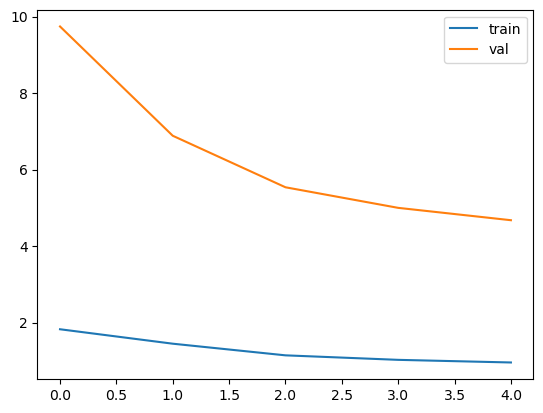

In [9]:
import pandas as pd
loss_df =  pd.DataFrame(loss_results)
loss_df.plot()

In [10]:
from sdm.models import SpatialTransformer, plot_predictions

model.eval()

# Make some predictions and plot the mask and the prediction in sub plots
arrays = []
with torch.no_grad():
    for i, (inputs, target, idxs) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)

        target_np = target.cpu().numpy()
        prediction_np = outputs.cpu().numpy()

        # iterate over the batch
        for i in range(len(target_np)):
            arrays.append({"target": target_np[i], "prediction": prediction_np[i]})
        

for i in range(5):
    plot_predictions(arrays[i]["target"], arrays[i]["prediction"])

In [ ]:
# Save the model
torch.save(model.state_dict(), "models/veg-height-cnn.pth")